In [27]:
import os

from rasterio.plot import reshape_as_image
from rasterio.plot import show
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import numpy as np
import cv2

from patchify import patchify
from PIL import Image

import urllib

import xml.etree.ElementTree as ET
import shapely
import geopandas as gpd

from io import BytesIO
from zipfile import ZipFile

rs = 42

In [89]:
# Download Bielefeld Mitte image for showcasing
bielefeld = "dop10rgbi_32_467_5763_1_nw_2020"
base_url = "https://www.opengeodata.nrw.de/produkte/geobasis/lusat/dop/dop_jp2_f10/"

img_url = f"{base_url}{bielefeld}.jp2"
bie_path = f"data/raw/images/{bielefeld}.jp2"
if not os.path.exists(bie_path):
    urllib.request.urlretrieve(img_url, bie_path)
    print(f"Downloaded {bielefeld}.jp2")
else:
    print(f"File {bielefeld}.jp2 already exists.")

gdf = get_shapefile((467000, 5763000)) # RUN CELL IN "DOWNLOAD SHAPEFILES"
gdf.to_file(f"data/raw/shapefiles/{bielefeld}.shp")
print(f"Saved {bielefeld}.shp")

File dop10rgbi_32_467_5763_1_nw_2020.jp2 already exists.
Saved dop10rgbi_32_467_5763_1_nw_2020.shp


## Download files via API

### Get metadata of satellite imagery

In [40]:
url_metadata = "https://www.opengeodata.nrw.de/produkte/geobasis/lusat/dop/dop_jp2_f10/dop_meta.zip"
trgt_filename = 'dop_nw.csv'

response = urllib.request.urlopen(url_metadata)
zipfile = ZipFile(BytesIO(response.read()))

metadata = pd.read_csv(zipfile.open(trgt_filename), 
                       sep=';', 
                       skiprows=5) # skip first 5 rows with irrelevant metadata

metadata.head(10)

,Kachelname,Erfassungsmethode,Aktualitaet,Bildflugnummer,Kamera_Sensor,Bodenpixelgroesse,Spektralkanaele,Koordinatenreferenzsystem_Lage,Koordinatenreferenzsystem_Hoehe,Bezugsflaeche,...,Anzahl_Zeilen,Farbtiefe,Standardabweichung,Dateiformat,Hintergrund,Quelldatenqualitaet,Kompression,Komprimierung,Belaubungszustand,Bemerkungen
0,dop10rgbi_32_375_5666_1_nw_2021,0,2021-06-02,1358/21 Leverkusen Wuppertal,DMCIII-27569_DMCIII,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",3,keine
1,dop10rgbi_32_438_5765_1_nw_2022,0,2022-03-10,1377/22 Greven Ibbenbüren,UCEM3-431S91898X119229-f100_UCE-M3,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
2,dop10rgbi_32_366_5723_1_nw_2020,0,2020-03-23,1333/20 Wesel Marl,UCEp-1-31011051_UCEp,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
3,dop10rgbi_32_344_5645_1_nw_2021,0,2021-03-02,1355/21 Düsseldorf Kerpen,UCEM3-431S71678X_UCE-M3,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
4,dop10rgbi_32_407_5744_1_nw_2022,0,2022-03-03,1379/22 Warendorf,DMCIII-27532_DMCIII,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
5,dop10rgbi_32_397_5744_1_nw_2022,0,2022-02-27,1378/22 Bocholt Coesfeld,UCEp-1-31011051-f100_UCEp,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
6,dop10rgbi_32_313_5624_1_nw_2021,0,2021-03-07,1356/21 Aachen Kronenburg,UCEM3-1-82416042_UCE-M3,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
7,dop10rgbi_32_335_5702_1_nw_2020,0,2020-03-24,1334/20 Duisburg Herne,UCEM3-431S51194X_UCE-M3,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
8,dop10rgbi_32_388_5791_1_nw_2022,0,2022-02-23,1376/22 Ahaus Rheine,UCEM3-431S41091X314298-f100_UCE-M3,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine
9,dop10rgbi_32_304_5671_1_nw_2021,0,2021-02-20,1354/21 Mönchengladbach- Würselen,UCEM3-431S72402X_UCE-M3,10,RGBI,25832,7837,bDOM,...,10000,8,20,JPEG2000,0,1,1,"GDAL_JP2ECW, 90",1,keine


### Download images

In [38]:
number_of_imgs = 10 # INCREASE THIS NUMBER TO DOWNLOAD MORE IMAGES
images_folder = "data/raw/images/"
base_url = "https://www.opengeodata.nrw.de/produkte/geobasis/lusat/dop/dop_jp2_f10/"

def download_image(img_url, save_path, rewrite=False):
    if not os.path.exists(save_path) or rewrite:
        urllib.request.urlretrieve(img_url, save_path)
        print(f"Downloaded {save_path}")
    else:
        print(f"File {save_path} already exists.")

In [41]:
# get list of filenames
metadata_sample = metadata.sample(number_of_imgs, random_state=rs)
imgs = list(metadata_sample['Kachelname'].values)

# download images
for img in imgs:
    img_url = f"{base_url}{img}.jp2"
    save_path = f"{images_folder}{img}.jp2"
    download_image(img_url, save_path, rewrite=False)
    

Downloaded data/raw/images/dop10rgbi_32_352_5693_1_nw_2020.jp2
Downloaded data/raw/images/dop10rgbi_32_466_5751_1_nw_2022.jp2
Downloaded data/raw/images/dop10rgbi_32_417_5715_1_nw_2021.jp2
Downloaded data/raw/images/dop10rgbi_32_379_5692_1_nw_2021.jp2
Downloaded data/raw/images/dop10rgbi_32_348_5715_1_nw_2020.jp2
Downloaded data/raw/images/dop10rgbi_32_489_5749_1_nw_2020.jp2
Downloaded data/raw/images/dop10rgbi_32_474_5802_1_nw_2020.jp2
Downloaded data/raw/images/dop10rgbi_32_357_5689_1_nw_2021.jp2
Downloaded data/raw/images/dop10rgbi_32_484_5752_1_nw_2020.jp2
Downloaded data/raw/images/dop10rgbi_32_361_5728_1_nw_2020.jp2


### Download shapefiles

In [88]:
def get_shapefile(bbox2:tuple, crs='EPSG:25832') -> gpd.GeoDataFrame:
    
    base_url = "https://www.wfs.nrw.de/geobasis/wfs_nw_alkis_vereinfacht?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&TYPENAMES=ave:GebaeudeBauwerk&BBOX="
    
    x, y = bbox2
    x2 = x + 1000
    y2 = y + 1000
    
    bbox4 = (x, y, x2, y2)
    
    bbox_str = ','.join(list(map(str, bbox4)))
    
    gml_url = ''.join([base_url, bbox_str])
    
    req = urllib.request.Request(gml_url)
    req.get_method = lambda: 'GET'
    response = urllib.request.urlopen(req)
    
    gml_str = response.read()
    
    root = ET.ElementTree(ET.fromstring(gml_str)).getroot()
    
    
    namespace = {'gml': "http://www.opengis.net/gml/3.2",
             'xlmns': "http://repository.gdi-de.org/schemas/adv/produkt/alkis-vereinfacht/2.0",
             'wfs': "http://www.opengis.net/wfs/2.0",
             'xsi': "http://www.w3.org/2001/XMLSchema-instance"
             }
    
    buildings = [i.text for i in root.findall('.//gml:posList', namespace)]
    
    #funktions = [i.text for i in root.iter('{http://repository.gdi-de.org/schemas/adv/produkt/alkis-vereinfacht/2.0}funktion')]
    
    ids = [i.items()[0][1] for i in root.findall('.//gml:MultiSurface[@gml:id]', namespace)]
    
    building_shapefiles = []
    
    for id, funktion, build in zip(ids, funktions, buildings):
        coord_iter = iter(build.split(' '))
        coords = list(map(tuple, zip(coord_iter, coord_iter)))
        
        poly = shapely.geometry.Polygon([[float(p[0]), float(p[1])] for p in coords])
        
        building_shapefiles.append({'id': id, 'funktion':funktion, 'geometry': poly})
    
    df = pd.DataFrame.from_records(building_shapefiles)
    gdf = gpd.GeoDataFrame(df, crs=crs)
    
    return gdf

In [49]:
bboxs_sample = list(zip(metadata_sample["Koordinatenursprung_East"], metadata_sample["Koordinatenursprung_North"]))

for bbox in bboxs_sample:
    gdf = get_shapefile(bbox)
    filename = metadata_sample.loc[metadata_sample['Koordinatenursprung_East'].eq(bbox[0]) & \
                                  metadata_sample['Koordinatenursprung_North'].eq(bbox[1])] \
                                  ["Kachelname"].item()
    gdf.to_file(f"data/raw/shapefiles/{filename}.shp")
    print(f"Saved {filename}.shp")

Saved dop10rgbi_32_352_5693_1_nw_2020.shp
Saved dop10rgbi_32_466_5751_1_nw_2022.shp
Saved dop10rgbi_32_417_5715_1_nw_2021.shp
Saved dop10rgbi_32_379_5692_1_nw_2021.shp
Saved dop10rgbi_32_348_5715_1_nw_2020.shp
Saved dop10rgbi_32_489_5749_1_nw_2020.shp
Saved dop10rgbi_32_474_5802_1_nw_2020.shp
Saved dop10rgbi_32_357_5689_1_nw_2021.shp
Saved dop10rgbi_32_484_5752_1_nw_2020.shp
Saved dop10rgbi_32_361_5728_1_nw_2020.shp


## Create image-mask pairs

In [2]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = shapely.ops.unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # Convert polygons to the image CRS
        poly_pts.append(~transform * tuple(i))
        
    # Generate a polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

def generate_mask(shapefiles, raster_meta):
    # Generate binary mask
    polygons = []
    im_size = (raster_meta["height"], raster_meta["width"])
    for num, row in shapefiles.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], raster_meta["transform"])
            polygons.append(poly)
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, raster_meta["transform"])
                polygons.append(poly)

    mask = rasterize(shapes=polygons, out_shape=im_size)
    
    return mask

In [75]:
rewrite = True

images_folder = "data/raw/images/"
shapefiles_folder = "data/raw/shapefiles/"

image_files = [f for f in os.listdir(images_folder)]
shapefiles = [f for f in os.listdir(shapefiles_folder) if f.endswith(".shp")]

counter = 1

for img, shp in zip(image_files, shapefiles):
    print(f"Processing pair {counter} of {len(image_files)}: {img[:-4]}")
    
    # get full file paths
    img_path= f"{images_folder}{img}"
    shp_path = f"{shapefiles_folder}{shp}"
    
    # read image and shapefile
    shapes = gpd.read_file(shp_path)
    src = rasterio.open(img_path, "r")
    shp = shp[:-4]
    img = img[:-4]
        
    # change profile to save as jpg
    profile = src.profile
    profile.update(driver = 'GTiff')
    profile['compress'] = 'JPEG'

    # Generate and save mask
    mask = generate_mask(shapes, profile)
    
    mask = mask.astype(rasterio.uint8)
    profile_mask = profile.copy()
    profile_mask.update(count = 1, dtype = rasterio.uint8)
    
    save_path = f"data/processed/masks/{img}.jpg"
    if not os.path.exists(save_path) or rewrite:
        with rasterio.open(save_path, 'w', **profile_mask) as dst:
            dst.write(mask * 255, 1)
    else:
        print(f"Mask for {img} already exists.")
    
    # Generate and save jpg
    img_rgb = src.read([1,2,3])
    src.close()
    
    profile_img = profile.copy()
    profile_img.update(count = 3)
    profile_img['photometric'] = 'YCbCr'
    
    save_path = f"data/processed/images/{img}.jpg"
    if not os.path.exists(save_path) or rewrite:
        with rasterio.open(save_path, 'w', **profile_img) as dst:
            dst.write(img_rgb)
    else:
        print(f"Image for {img} already exists.")
        
    counter += 1

Processing pair 1 of 11: dop10rgbi_32_348_5715_1_nw_2020
Processing pair 2 of 11: dop10rgbi_32_352_5693_1_nw_2020
Processing pair 3 of 11: dop10rgbi_32_357_5689_1_nw_2021
Processing pair 4 of 11: dop10rgbi_32_361_5728_1_nw_2020
Processing pair 5 of 11: dop10rgbi_32_379_5692_1_nw_2021
Processing pair 6 of 11: dop10rgbi_32_417_5715_1_nw_2021
Processing pair 7 of 11: dop10rgbi_32_466_5751_1_nw_2022
Processing pair 8 of 11: dop10rgbi_32_467_5763_1_nw_2020
Processing pair 9 of 11: dop10rgbi_32_474_5802_1_nw_2020
Processing pair 10 of 11: dop10rgbi_32_484_5752_1_nw_2020
Processing pair 11 of 11: dop10rgbi_32_489_5749_1_nw_2020


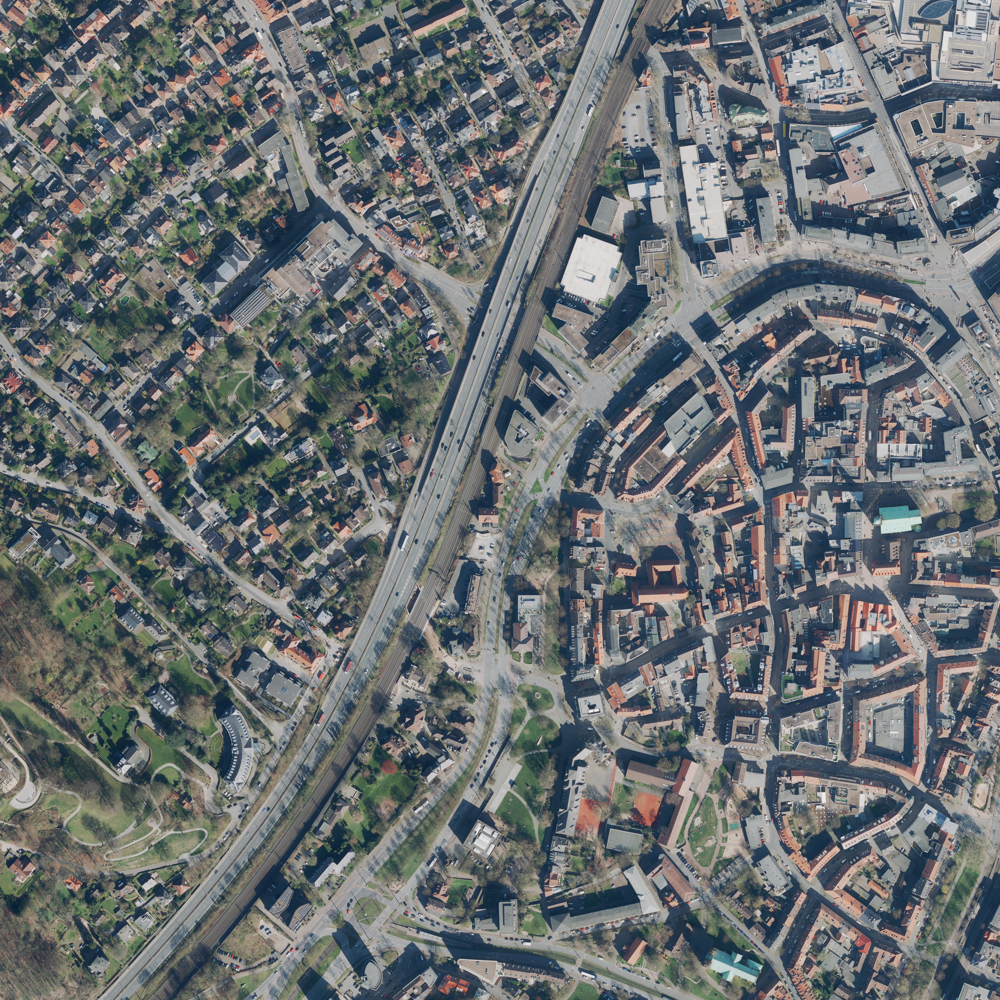

In [98]:
Image.open(f'data\processed\images\{bielefeld}.jpg').resize((1000,1000))

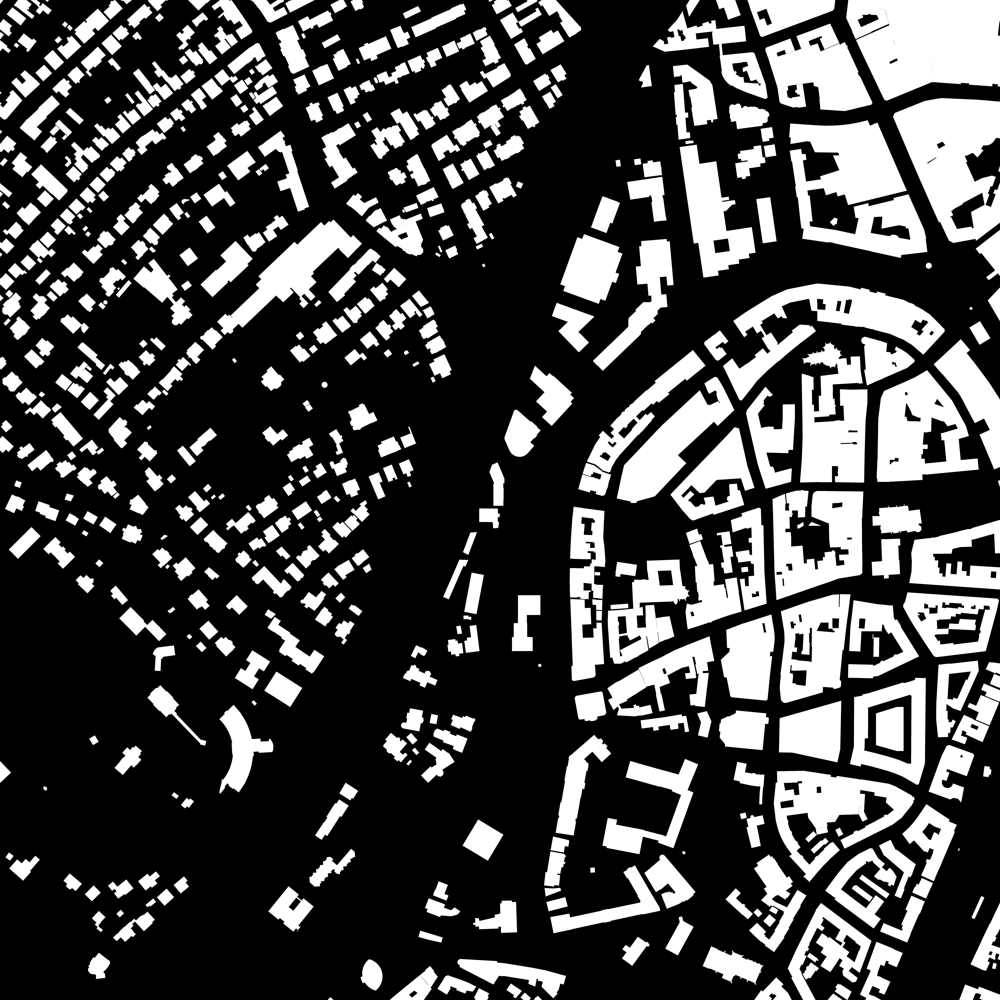

In [99]:
Image.open(f'data\processed\masks\{bielefeld}.jpg').resize((1000,1000))

## Break down images into smaller parts